<a href="https://colab.research.google.com/github/abyaadrafid/BHGD/blob/master/bangla_handwritten_grapheme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import torchvision
from torchvision import transforms
from torchvision import models
from collections import Counter
from pathlib import Path
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sn
# !pip install torchsummary 
# import torchsummary

In [4]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.20.5 (Git Hash 0125f28c61c1f822fd48570b4c1066f96fcb9b2e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -fopenmp -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variable -Wno-unused-function -Wno-unused-result -Wno-strict-overflow -Wno-strict-aliasing -Wno-error=deprecated-declarations -Wno-stringop-overflow -Wno-error=pedantic -Wno-error=redundant-decls -Wno-error=old-style-cast -fdiagnostics-color=always -faligned-new -Wno-unused-but-set-variable -Wno-maybe-uninitialized -fno-math-errno -fno-trapping-

In [5]:
torch.get_num_threads()

2

In [0]:
torch.set_num_threads(4)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df_train = pd.read_csv('/content/gdrive/My Drive/kaggle/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/kaggle/test.csv')
df_class = pd.read_csv('/content/gdrive/My Drive/kaggle/class_map.csv')
df_submission = pd.read_csv('/content/gdrive/My Drive/kaggle/sample_submission.csv')

In [0]:
def make_tensordataset_from_dfs(parquet_locs, label_loc=None):
    ids = []
    X = []
#     parquet_locs = notebook.tqdm(parquet_locs)
    for parquet_loc in parquet_locs:
        df = pd.read_parquet(parquet_loc)
        ids.extend(df.image_id.tolist())
        x = df.iloc[:, 1:].to_numpy(dtype=np.uint8)
        del df
        X.append(x)
    X = np.vstack(X)
    X = X.reshape(-1, 1, 137, 236)
    X = torch.from_numpy(X)
    ids = dict((s,i) for (i,s) in enumerate(ids))
    if label_loc is None:
        return TensorDataset(X)
    else:
        graphemes = torch.zeros(X.shape[0], dtype=torch.long)
        vowel_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        consonant_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        lbl_df = pd.read_csv(label_loc)
        for row in lbl_df.itertuples():
            if row.image_id not in ids:
                continue
            idx = ids[row.image_id]
            graphemes[idx] = row.grapheme_root
            vowel_diacs[idx] = row.vowel_diacritic
            consonant_diacs[idx] = row.consonant_diacritic
        return TensorDataset(X, graphemes, vowel_diacs, consonant_diacs)

In [0]:
ds = make_tensordataset_from_dfs(['/content/gdrive/My Drive/kaggle/train_image_data_{}.parquet'.format(i) for i in range(4)], '/content/gdrive/My Drive/kaggle/train.csv')

(tensor(72),
 tensor(4),
 tensor(0),
 tensor(255, dtype=torch.uint8),
 tensor(34, dtype=torch.uint8))

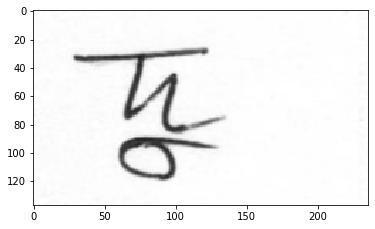

In [12]:
plt.imshow(ds[100000][0].permute(1, 2, 0).reshape(137, 236), cmap='gray', vmin=0, vmax=255)
ds[100000][1], ds[100000][2], ds[100000][3], ds[100000][0].max(), ds[100000][0].min()

In [0]:
# tmp = torch.nonzero(ds[100000][0] < 100)

In [0]:
# tmp[:, 1].max(), tmp[:, 1].min(), tmp[:, 2].max(), tmp[:, 2].min()

In [0]:
tr_indices, va_indices = train_test_split(list(range(len(ds))), test_size=.1, train_size=.9, random_state=42)#, stratify=ds.tensors[1])

In [0]:
tr_ds = Subset(ds, tr_indices)
va_ds = Subset(ds, va_indices)

In [17]:
len(ds), len(tr_ds), len(va_ds)

(200840, 180756, 20084)

In [0]:
n_graphemes, n_vowel_diacs, n_consonant_diacs = len(set(df_train['grapheme_root'])), len(set(df_train['vowel_diacritic'])), len(set(df_train['consonant_diacritic']))

In [0]:
def make_linear_block(in_size, out_size):
    block = nn.Sequential(
        nn.Linear(in_size, out_size), 
        nn.ReLU(), 
        nn.BatchNorm1d(num_features=out_size),
    )
    nn.init.xavier_normal_(block[0].weight.data)
    nn.init.zeros_(block[0].bias.data)
    return block

def make_ff_predictor(in_size, intermediate_size, out_size, layer_count):
    layers = [make_linear_block(in_size, intermediate_size)]
    for i in range(layer_count):
        layers.append(make_linear_block(intermediate_size, intermediate_size))
    layers.append(nn.Linear(intermediate_size, out_size))
    layers = nn.Sequential(*layers)
    return layers

class BanglaHandwrittenGraphemeNN(nn.Module):
    def __init__(self):
        super(BanglaHandwrittenGraphemeNN, self).__init__()
#         base = models.squeezenet1_0(pretrained=True).features
        base = models.resnet18(pretrained=False)
        base.fc = nn.Identity()
        self.base = base
        feature_size = 512
        self.grapheme_predictor = make_ff_predictor(feature_size, 512, n_graphemes, 2)
        self.vowel_diac_predictor = make_ff_predictor(feature_size, 512, n_vowel_diacs, 1)
        self.consonant_diacs = make_ff_predictor(feature_size, 512, n_consonant_diacs, 1)

    def convert_to_grayscale(self):
        with torch.no_grad():
            conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            conv1.weight.data = torch.sum(model.base.conv1.weight.data, dim=1, keepdim=True)
            self.base.conv1 = conv1
            
    def freeze(self):
        for p in self.base.parameters():
            p.requires_grad = False
        
    def unfreeze(self):
        for p in self.base.parameters():
            p.requires_grad = True
        
    def forward(self, x):
#         with torch.no_grad():
        features = self.base(x)
        g_pred = self.grapheme_predictor(features)
        v_pred = self.vowel_diac_predictor(features)
        c_pred = self.consonant_diacs(features)
        return g_pred, v_pred, c_pred

In [0]:
class MultiTaskLoss(nn.Module):
    def __init__(self, num_tasks, init_weight=None):
        super(MultiTaskLoss, self).__init__()
        self.n = num_tasks
        if init_weight is None:
            self.w = nn.Parameter(torch.ones(self.n))
        else:
            self.w = nn.Parameter(torch.tensor(init_weight))

    def forward(self, losses):
        return torch.sum(self.w * losses) - torch.sum(torch.sum(torch.log(self.w)))

In [0]:
model = BanglaHandwrittenGraphemeNN().to(device)

In [0]:
model.convert_to_grayscale()

In [0]:
model.unfreeze()

In [0]:
tr_dl = DataLoader(tr_ds, batch_size=256, num_workers=0,shuffle=True)
va_dl = DataLoader(va_ds, batch_size=256, num_workers=0)

In [0]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
tr_losses = []
va_losses = []

In [0]:
mean = lambda l: sum(l) / len(l)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [0]:
def run_epochs(num_epochs):
  epochs = range(num_epochs)
  epochs = tqdm_notebook(range(num_epochs))
  for epoch in epochs:
      model.train()
      count = 0
      batches = tr_dl
      batches = tqdm_notebook(tr_dl)
      for batch in batches:
          count += 1
          optimizer.zero_grad()
          img, g, v, c = batch
          img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
          img = img / 255.0
          img,g_a,g_b,lam=mixup_data(img,g,alpha=0.25)
          img,v_a,v_b,lam=mixup_data(img,g,alpha=0.0)
          img,c_a,c_b,lam=mixup_data(img,g,alpha=0.0)

          g_pred, v_pred, c_pred = model(img)
          g_loss = mixup_criterion(criterion,g_pred, g_a,g_b,lam)
          v_loss = criterion(v_pred,v)
          c_loss = criterion(c_pred,c)
          loss = g_loss + v_loss + c_loss
          loss.backward()
          optimizer.step()
          tr_losses.append((g_loss.item(), v_loss.item(), c_loss.item()))
      print(mean([sum(t) for t in tr_losses]), mean([t[0] for t in tr_losses]), mean([t[1] for t in tr_losses]), mean([t[2] for t in tr_losses]))
      with torch.no_grad():
          model.eval()
          avg_g_loss = 0.0
          avg_v_loss = 0.0
          avg_c_loss = 0.0
          g_true = []
          v_true = []
          c_true = []
          g_preds = []
          v_preds = []
          c_preds = []
          count = 0
          batches = va_dl
          batches = tqdm_notebook(va_dl)
          for batch in batches:
              count += 1
              img, g, v, c = batch
              img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
              img = img / 255.0
              img,g_a,g_b,lam=mixup_data(img,g,alpha=0.25)
              g_pred, v_pred, c_pred = model(img)
              g_loss = mixup_criterion(criterion,g_pred, g_a,g_b,lam)
              v_loss = criterion(v_pred,v)
              c_loss = criterion(c_pred,c)
              avg_g_loss += g_loss.item()
              avg_v_loss += v_loss.item()
              avg_c_loss += c_loss.item()
              g_true.extend(g.tolist())
              v_true.extend(v.tolist())
              c_true.extend(c.tolist())
              g_preds.extend(g_pred.argmax(1).tolist())
              v_preds.extend(v_pred.argmax(1).tolist())
              c_preds.extend(c_pred.argmax(1).tolist())
          avg_g_loss /= count
          avg_v_loss /= count
          avg_c_loss /= count
          va_losses.append((avg_g_loss, avg_v_loss, avg_c_loss))
          print(sum(va_losses[-1]), va_losses[-1])
          
          print(recall_score(g_true, g_preds, average='macro'))
          print(recall_score(v_true, v_preds, average='macro'))
          print(recall_score(c_true, c_preds, average='macro'))
          print(confusion_matrix(v_true, v_preds))
          print(confusion_matrix(c_true, c_preds))
          plt.figure(figsize = (20, 20))
          sn.heatmap(np.log1p(confusion_matrix(g_true, g_preds)))
          plt.show()

In [0]:
run_epochs(4)

In [0]:
run_epochs(3)

In [0]:
plt.plot([sum(t) for t in tr_losses])

In [0]:
plt.plot([t[0] for t in tr_losses])

In [0]:
plt.plot([t[1] for t in tr_losses])

In [0]:
plt.plot([t[2] for t in tr_losses])

In [0]:
plt.plot([t[0] for t in va_losses])

In [0]:
plt.plot([t[1] for t in va_losses])

In [0]:
plt.plot([t[2] for t in va_losses])

In [0]:
torch.save(model.state_dict(), 'model.pth')